In [276]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sunpy.coordinates import frames
import sunpy.map
from astropy.coordinates import SkyCoord, angles
from astropy import units as u 
import datetime
from astropy.coordinates import SkyCoord, CylindricalRepresentation
import numpy as np 
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

# flare list

In [258]:
flare_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/goes_flare_list/final_flare_list.csv")
flare_list = flare_list.set_index(pd.to_datetime(flare_list["event_starttime"]))
flare_list.sort_index(inplace=True)
flare_list["event_starttime"] = pd.to_datetime(flare_list["event_starttime"])


hpc_coords = SkyCoord(flare_list["hpc_x"]*u.arcsec, flare_list["hpc_y"]*u.arcsec, 
                      frame=frames.Helioprojective, obstime=flare_list["event_starttime"], 
                      observer="earth")

hcr_coords = hpc_coords.transform_to(frames.Heliocentric)
phi = hcr_coords.cylindrical.phi.wrap_at(360*u.deg).value
flare_list.loc[(pd.to_datetime(flare_list.event_endtime)<flare_list.event_starttime),'event_endtime']=pd.to_datetime(flare_list["event_endtime"]) + datetime.timedelta(days=1)
flare_list.loc[(pd.to_datetime(flare_list.event_peaktime)<flare_list.event_starttime),'event_peaktime']=pd.to_datetime(flare_list["event_peaktime"]) + datetime.timedelta(days=1)

def get_new_phis(x):
    if np.isnan(x):
        return np.nan
    else:
        return (angles.Angle(phi[0]*u.deg) - 90*u.deg).wrap_at(360*u.deg).value
# 90 degrees offset in the way sunpy makes it
new_phis = [get_new_phis(x) for x in phi]
flare_list["phi"] = phi-90#new_phis

In [259]:
flare_list["phi"].unique()
flare_list.loc[(flare_list.phi < 0),'phi']=flare_list.phi+360

(array([ 180.,  662., 1903., 1211.,  284.,  305., 1046., 1718.,  784.,
         209.]),
 array([  0.        ,  35.83854659,  71.67709318, 107.51563978,
        143.35418637, 179.19273296, 215.03127955, 250.86982614,
        286.70837273, 322.54691933, 358.38546592]),
 <BarContainer object of 10 artists>)

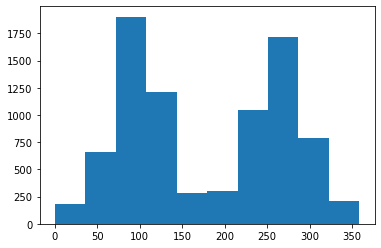

In [260]:
plt.hist(flare_list["phi"])

(array([1030., 1834., 2461., 1581.,  577.,  637., 1617., 2268., 1737.,
        1022.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

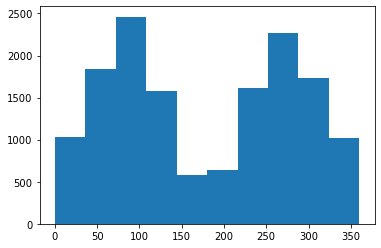

In [261]:
plt.hist(cme_list["MPA"])

# CME list 

In [262]:
cme_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/cme_lists/final_cme_list_2010_2018.csv")
cme_list["start_time_c2"] = pd.to_datetime(cme_list.date + cme_list.time, format="%Y/%m/%d%H:%M:%S") 
#cme_list = cme_list.set_index(pd.to_datetime(cme_list.date + cme_list.time, format="%Y/%m/%d%H:%M:%S"))
def get_times(x):
    xx = x.split()
    if len(xx)==3:
        return pd.to_datetime(" ".join(xx[1:]))
    else:
        return np.nan

cme_list["onset_times1"] = cme_list.onset_times1.map(get_times)
cme_list["onset_times2"] = cme_list.onset_times2.map(get_times)

In [555]:
#flare_xm = flare_list[flare_list["goes_class_ind"].isin(["X", "M"])]

In [556]:
flare_xm = flare_list[flare_list["goes_class_val"]>=5e-6]

In [580]:
flare_xm["goes_class_ind"].value_counts()

C    980
M    748
X     49
Name: goes_class_ind, dtype: int64

## Lets merge the two together

In [557]:
cme_list.head()

,date,time,central_pa,width,linear_speed,2nd_order_speed_inital,2nd_order_speed_final,2nd_order_speed_20R,accel,mass,kinetic_energy,MPA,remarks,time_c2,onset_times1,onset_times2,onset_times2_rsun,quality_index,quality_val,start_time_c2
0,2010/01/01,06:54:03,354,6,330,269,396,959,35.5*,-------,-------,355,Very Poor Event; Only 3 points; Only C2,2010-01-01 06:54:03,2010-01-01 05:50:03,2010-01-01 04:48:01,#ONSET2_RSUN: 1.38,#QUALITY_INDEX: 0 (Ill-Defined),0,2010-01-01 06:54:03
1,2010/01/01,08:30:03,248,75,148,60,244,220,1.9*,4.2e+14,4.6e+28,253,Poor Event,2010-01-01 08:30:03,2010-01-01 07:11:32,2009-12-31 23:10:35,#ONSET2_RSUN: 1.98,#QUALITY_INDEX: 1 (Poor),1,2010-01-01 08:30:03
2,2010/01/01,17:06:03,49,21,729,764,694,700,-3.9,4.0e+14,1.1e+30,52,NaN,2010-01-01 17:06:03,2010-01-01 16:45:44,2010-01-01 16:48:50,#ONSET2_RSUN: 1.00,#QUALITY_INDEX: 3 (Typical),3,2010-01-01 17:06:03
3,2010/01/02,07:31:38,100,14,141,123,159,176,0.8*,-------,-------,106,Very Poor Event,2010-01-02 07:31:38,2010-01-02 02:18:04,2010-01-02 00:45:03,#ONSET2_RSUN: 1.00,#QUALITY_INDEX: 0 (Ill-Defined),0,2010-01-02 07:31:38
4,2010/01/03,05:30:03,267,50,219,73,375,385,5.9*,6.3e+14,1.5e+29,261,NaN,2010-01-03 05:30:03,2010-01-03 05:43:23,2010-01-03 02:22:08,#ONSET2_RSUN: 1.96,#QUALITY_INDEX: 2 (Fair),2,2010-01-03 05:30:03


In [558]:
def find_cme(i):
    # check its within 3 hours of flare
    cme_list_compare = cme_list[(cme_list["start_time_c2"]>=flare_xm.iloc[i]["event_starttime"]\
                                 -datetime.timedelta(minutes=30)) &
                                (cme_list["start_time_c2"]<=flare_xm.iloc[i]["event_starttime"]\
                                 +datetime.timedelta(hours=2))]
    # make sure the position locations make sense
    cme_list_compare = cme_list_compare[np.abs(cme_list_compare.MPA - flare_xm.iloc[i].phi)<=45]
    if len(cme_list_compare)==0:
        return "no", np.nan, 0
    elif len(cme_list_compare)==1:
        return "yes", np.abs(cme_list_compare.MPA - flare_xm.iloc[i].phi).values[0], cme_list_compare.quality_val.values[0]
    else:
        print("more that one! {:d} has {:d} CMEs".format(i, len(cme_list_compare)))
        print(cme_list_compare.quality_val.values, np.abs(cme_list_compare.MPA - flare_xm.iloc[i].phi).values)
        return "yes", np.abs(cme_list_compare.MPA - flare_xm.iloc[i].phi).values[0], cme_list_compare.quality_val.values[0]
        #return "CME (more that 1!) {:d} has {:d} CMEs".format(i, len(cme_list_compare))
    

        

In [559]:
cme_list_compare.width

39    46
40     4
Name: width, dtype: int64

In [560]:
cmes = []; angle_list = []; qual = []
for i in range(len(flare_xm)):
    cme, ang, q = find_cme(i)
    cmes.append(cme)
    angle_list.append(ang)
    qual.append(q)
flare_xm["cmes"] = cmes
flare_xm["angles"] = angle_list
flare_xm["qual"] = qual

more that one! 120 has 2 CMEs
[1 2] [42.65189248 24.34810752]
more that one! 142 has 2 CMEs
[2 3] [9.61772999 4.61772999]
more that one! 165 has 2 CMEs
[1 1] [19.80993285 23.19006715]
more that one! 183 has 2 CMEs
[1 0] [41.45804977  0.45804977]
more that one! 215 has 2 CMEs
[1 2] [36.46176022 34.46176022]
more that one! 235 has 2 CMEs
[0 1] [ 8.44699323 11.44699323]
more that one! 260 has 2 CMEs
[4 5] [20.45174259 14.45174259]
more that one! 274 has 2 CMEs
[1 2] [24.9888431 32.0111569]
more that one! 294 has 2 CMEs
[1 2] [1.11029341 5.11029341]
more that one! 321 has 2 CMEs
[3 5] [15.92415176  7.92415176]
more that one! 336 has 2 CMEs
[3 4] [18.28252332  3.28252332]
more that one! 354 has 2 CMEs
[5 3] [ 6.89153332 31.89153332]
more that one! 400 has 2 CMEs
[5 2] [16.08065583 22.08065583]
more that one! 425 has 2 CMEs
[2 4] [12.64020738 11.64020738]
more that one! 426 has 2 CMEs
[2 4] [10.  9.]
more that one! 434 has 2 CMEs
[2 4] [ 1.11403243 12.88596757]
more that one! 435 has 2 CMEs


In [561]:
flare_x = flare_xm[flare_xm["goes_class_ind"].isin(["X"])]
flare_m = flare_xm[flare_xm["goes_class_ind"].isin(["M"])]

print("X \n",100*flare_x["cmes"].value_counts()/len(flare_x))
print("M \n",100*flare_m["cmes"].value_counts()/len(flare_m))

X 
 yes    81.632653
no     18.367347
Name: cmes, dtype: float64
M 
 no     53.475936
yes    46.524064
Name: cmes, dtype: float64


In [562]:
flare_xm["dur_peak"] = [x.total_seconds() for x in pd.to_datetime(flare_xm["event_peaktime"]) - pd.to_datetime(flare_xm["event_starttime"])]
flare_xm["dur_full"] = [x.total_seconds() for x in pd.to_datetime(flare_xm["event_endtime"]) - pd.to_datetime(flare_xm["event_starttime"])]


In [563]:
flare_cmes = flare_xm[(flare_xm.qual>1)]
flare_nocmes = flare_xm[(flare_xm.qual<=1)]

In [564]:
~flare_xm.qual.isin([2, 3, 4, 5])

event_starttime
2010-01-19 08:34:00     True
2010-01-19 13:03:00     True
2010-01-19 17:44:00     True
2010-01-19 20:23:00     True
2010-01-20 04:48:00     True
                       ...  
2017-09-09 22:04:00    False
2017-09-10 02:40:00     True
2017-09-10 15:35:00    False
2017-10-20 23:10:00    False
2018-02-07 13:31:00     True
Name: qual, Length: 1777, dtype: bool

In [565]:
len(flare_cmes.dur_full)

429

In [566]:
len(flare_nocmes)

1348

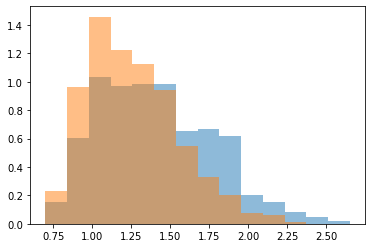

In [567]:
from astropy.visualization import hist
n, bins, _ = hist(np.log10(flare_cmes.dur_full/60), bins="freedman", alpha=0.5, density=True)
_ = hist(np.log10(flare_nocmes.dur_full/60), bins=bins, alpha=0.5, density=True)

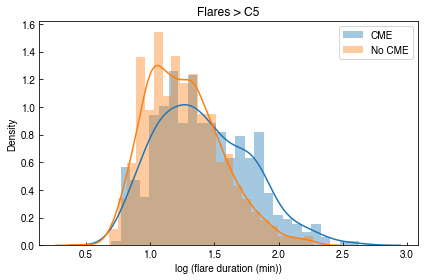

In [579]:
plt.rcParams['font.family'] = 'Helvetica'
sns.distplot(np.log10(flare_cmes.dur_full/60), bins=26, label="CME")
sns.distplot(np.log10(flare_nocmes.dur_full/60), bins=26, label="No CME")
plt.legend()
plt.xlabel("log (flare duration (min))")
plt.title("Flares > C5")
ax = plt.gca()
ax.tick_params(which="both", direction="in")
plt.tight_layout()
plt.savefig("flare_duration_cme_c5.png", dpi=300, facecolor="w")
# sns.distplot(np.log10(flare_xm.dur_full))

In [569]:
flare_xm = flare_xm[flare_xm.dur_peak>0]
flare_xm = flare_xm[~flare_xm.dur_peak.isnull()]

In [570]:
flare_cmes = flare_xm[(flare_xm.qual>1)]
flare_nocmes = flare_xm[(flare_xm.qual<=1)]

<AxesSubplot:xlabel='dur_peak', ylabel='Density'>

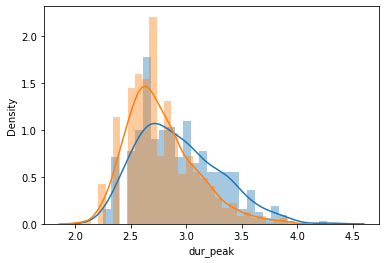

In [573]:
%matplotlib inline
sns.distplot(np.log10(flare_cmes.dur_peak), bins=28, label="CMEs")
sns.distplot(np.log10(flare_nocmes.dur_peak), bins=28, label="No CMEs")


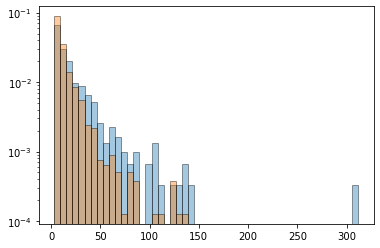

In [499]:
_, bins, _ = plt.hist(flare_cmes.dur_peak/60, bins=50, alpha=0.4, edgecolor="k", density=True)
_ = plt.hist(flare_nocmes.dur_peak/60, bins=bins, alpha=0.4, edgecolor="k", density=True)
plt.yscale("log")


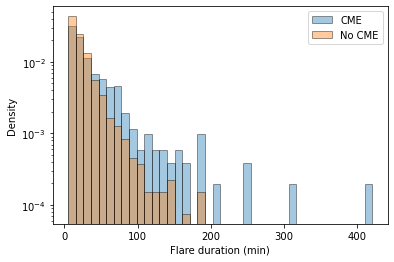

In [500]:
_, bins, _ = plt.hist(flare_cmes.dur_full/60, bins=40, alpha=0.4, edgecolor="k", density=True, label="CME")
_ = plt.hist(flare_nocmes.dur_full/60, bins=bins, alpha=0.4, edgecolor="k", density=True, label="No CME")
plt.yscale("log")
plt.xlabel("Flare duration (min)")
plt.ylabel("Density")
plt.legend()

In [256]:
i = 4
cme_list_compare = cme_list[(cme_list["start_time_c2"]>=flare_xm.iloc[i]["event_starttime"]\
                             -datetime.timedelta(hours=1)) &
                            (cme_list["start_time_c2"]<=flare_xm.iloc[i]["event_starttime"]\
                             +datetime.timedelta(hours=2))]

In [63]:
np.abs(cme_list_compare.MPA - flare_xm.iloc[i].phi).values[0]

15.725976959580521

X 
 yes    73.469388
no     26.530612
Name: cmes, dtype: float64
M 
 no     56.684492
yes    43.315508
Name: cmes, dtype: float64
